
Image Classification ...

Last Updated: July 1st, 2025

Daily Challenge: Image Classification with Data Augmentation (Cats vs Dogs)


👩‍🏫 👩🏿‍🏫 What You’ll learn

    How to preprocess image data for a convolutional neural network (CNN).
    How to apply data augmentation techniques to improve model generalization.
    How to build and train a CNN for binary image classification.
    How to use dropout to reduce overfitting in a neural network.


🛠️ What you will create

    A binary image classification model to distinguish between images of cats and dogs.
    A visualization of training and validation metrics to analyze model performance.


⚠️ Warning ! In this daily challenge, you need to use a VM like DigitalOcean! ⚠️


What You Need to Do

1. Preprocess the Data:

    Download and extract the Cats vs Dogs dataset here.
    Use ImageDataGenerator to rescale and augment the training images (e.g., horizontal flip, rotation, zoom, and shifts).

Here is a hint:


train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                       directory=train_dir,
                                                       shuffle=True,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=validation_dir,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='binary')


    Create separate generators for training and validation data.

2. Build the Model:

    Create a CNN with:
        Three convolutional layers with ReLU activation and max-pooling.
        Dropout layers to reduce overfitting.
        A fully connected layer with 512 units and ReLU activation.
        An output layer with a single unit and sigmoid activation for binary classification.
    Compile the model using the Adam optimizer and binary cross-entropy loss.

3. Train the Model:

    Train the model on the augmented training data for 15 epochs.
    Use the validation data to monitor performance during training.

4. Evaluate the Model:

    Plot the training and validation accuracy and loss to detect overfitting.
    Analyze the impact of data augmentation and dropout on model performance.

5. Bonus:

Retry training the model after Data augmentation: Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.
There is multiple methods to augment data:

    Apply horizontal flip
    Randomly rotate the image
    Apply zoom augmentation

Here the code for Data Augmentation

## Apply horizontal flip
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
# Found 2000 images belonging to 2 classes.
# Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times
augmented_images = [train_data_gen[0][0][0] for i in range(5)]


## Randomly rotate the image
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Found 2000 images belonging to 2 classes.


## Apply zoom augmentation
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.

#Put it all together
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
Found 2000 images belonging to 2 classes.
augmented_images = [train_data_gen[0][0][0] for i in range(5)]


Create validation data generator

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')
Found 1000 images belonging to 2 classes.




In [32]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [3]:
# Chemin vers le dossier d'origine
base_dir = 'Dogs vs Cats/train/train'
target_dir = 'Dogs vs Cats/train_sorted'

# Création des dossiers cibles
os.makedirs(os.path.join(target_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'dogs'), exist_ok=True)

# Déplacement des fichiers dans le bon dossier
for filename in os.listdir(base_dir):
    if filename.startswith('cat'):
        shutil.copy(os.path.join(base_dir, filename), os.path.join(target_dir, 'cats', filename))
    elif filename.startswith('dog'):
        shutil.copy(os.path.join(base_dir, filename), os.path.join(target_dir, 'dogs', filename))
    else:
        print(f"Fichier ignoré (nom non reconnu) : {filename}")

Quand on utilise ImageDataGenerator avec la méthode flow_from_directory(), Keras a besoin d'une structure par classe pour attribuer automatiquement les labels à chaque image. Par défaut :

    Chaque sous-dossier dans train/ est interprété comme une classe.

    Donc train/cats/ et train/dogs/, via Keras deviennent les classes [0,1].

Les images doivent être préparées pour l’entraînement d’un réseau de neurones convolutif. Cela implique plusieurs opérations :

    Les images sont redimensionnées à une taille fixe (150x150 pixels) afin de garantir une entrée homogène dans le réseau.

    Les valeurs de pixels sont normalisées dans l’intervalle [0, 1] via une division par 255.

    Une augmentation de données est appliquée sur l’ensemble d’entraînement pour simuler de nouvelles images. Cela permet d’améliorer la généralisation du modèle et de limiter le surapprentissage. Les transformations incluent des rotations aléatoires, des décalages horizontaux et verticaux, du zoom, des renversements horizontaux, et du cisaillement.

    Le jeu de données est divisé automatiquement en deux sous-ensembles : 80 % pour l'entraînement, 20 % pour la validation.

In [13]:
# Paramètres
image_size = (150, 150)
batch_size = 32

# Générateur avec augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Générateur entraînement
train_generator = train_datagen.flow_from_directory(
    'Dogs vs Cats/train_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Générateur validation
validation_generator = train_datagen.flow_from_directory(
    'Dogs vs Cats/train_subset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


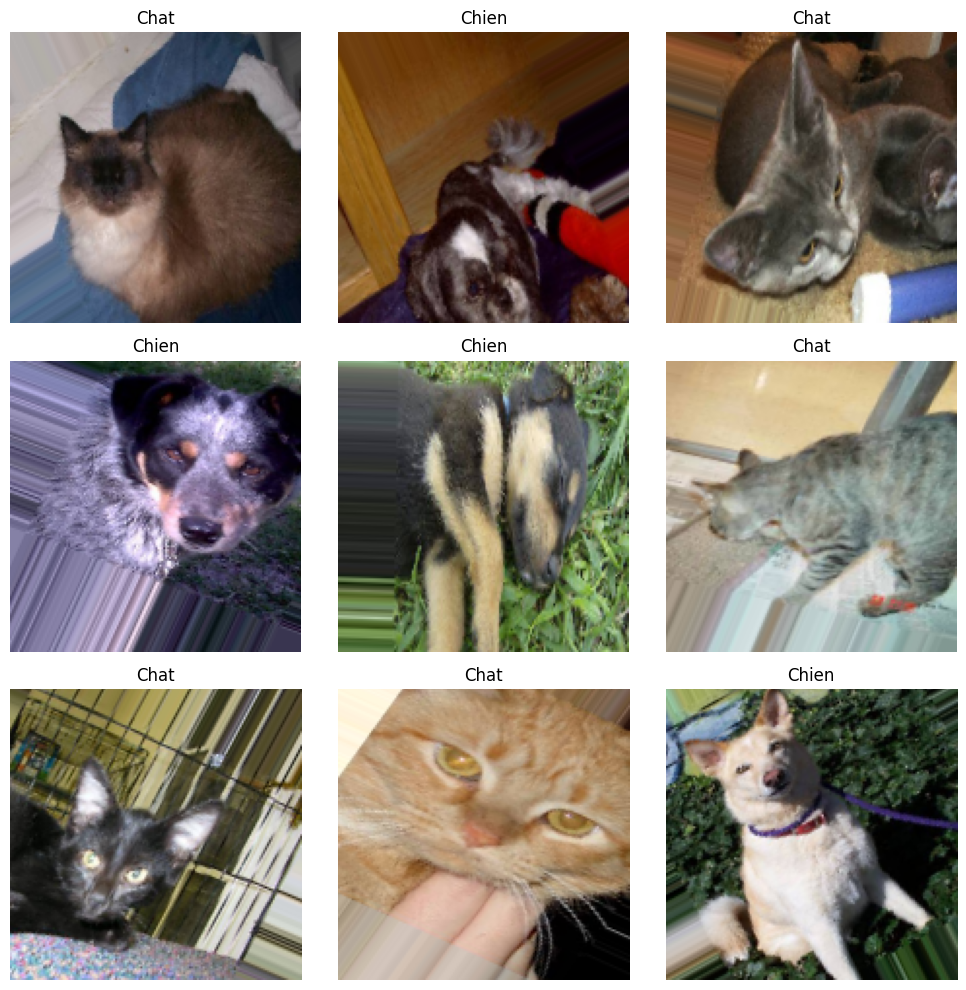

In [ ]:
# Génération d’un batch aléatoire d’images
images, labels = next(train_generator)

# Affichage des 9 premières images avec leur étiquette
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = "Chien" if labels[i] == 1 else "Chat"
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

Ce bloc de code configure deux flux de données prêts à être utilisés pour l’entraînement d’un modèle de classification binaire.

Lors de l'entraînement sur une machine locale sans GPU, les performances sont fortement limitées par la puissance du processeur. Dans le cas d’un modèle CNN, chaque époque peut durer plusieurs minutes, voire plusieurs dizaines, selon la taille et la résolution des images.

Travailler avec un sous-ensemble du dataset présente plusieurs avantages :

    Accélère le temps d'entraînement et de validation.

    Permet de valider rapidement que l’architecture du modèle est correcte.

    Permet de repérer les erreurs de traitement, de chargement ou de surapprentissage dès les premières itérations.

    Réduit les risques de surchauffe ou d’instabilité système sur une machine personnelle.

Ce type d’échantillonnage est utile dans une phase de prototypage. Il ne remplace pas un entraînement complet mais le prépare efficacement.

In [12]:
def subset_dataset(source_dir, target_dir, class_names, n_images_per_class):
    os.makedirs(target_dir, exist_ok=True)
    for class_name in class_names:
        src = os.path.join(source_dir, class_name)
        dst = os.path.join(target_dir, class_name)
        os.makedirs(dst, exist_ok=True)

        all_images = os.listdir(src)
        selected_images = random.sample(all_images, n_images_per_class)

        for img in selected_images:
            src_path = os.path.join(src, img)
            dst_path = os.path.join(dst, img)
            shutil.copy(src_path, dst_path)

# Paramètres du sous-échantillon
subset_dataset(
    source_dir='Dogs vs Cats/train_sorted',
    target_dir='Dogs vs Cats/train_subset',
    class_names=['cats', 'dogs'],
    n_images_per_class=1000
)


Ce script peut être lancé une fois pour créer le dataset allégé. Les images sont copiées (pas déplacées), de sorte que le jeu de données complet reste disponible si besoin.

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

Trois blocs convolutionnels

    Chaque bloc est composé d’une couche de convolution 2D suivie d’un max-pooling.

    La fonction d’activation utilisée est ReLU (Rectified Linear Unit), qui introduit de la non-linéarité et permet d’accélérer la convergence.

    Le pooling permet de réduire la dimension spatiale tout en conservant les caractéristiques discriminantes les plus importantes.

Couches de dropout

    Intégrées à deux niveaux du réseau pour désactiver aléatoirement une fraction des neurones pendant l'entraînement.

    Permettent de réduire le risque de surapprentissage en forçant le modèle à ne pas s’appuyer sur un petit ensemble de neurones spécifiques.

Couche entièrement connectée (dense)

    Composée de 512 unités avec activation ReLU.

    Cette couche transforme les cartes de caractéristiques extraites en un espace vectoriel utilisé pour la décision finale.

Couche de sortie

    Une seule unité avec activation sigmoid.

    La sortie est une probabilité comprise entre 0 et 1 indiquant l’appartenance à la classe cible (ex : 1 pour "chien", 0 pour "chat").

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Données d'entraînement : issues de la génération par ImageDataGenerator, avec des transformations aléatoires appliquées à chaque batch (rotation, zoom, flip, etc.). Cette augmentation simule une plus grande diversité de cas visuels à partir d’un dataset réduit.

Données de validation : extraites automatiquement du même répertoire, mais sans augmentation, afin de mesurer objectivement les performances du modèle sur des images non vues et non altérées.

steps_per_epoch correspond au nombre de batches à traiter à chaque epoch. Il est calculé automatiquement comme le nombre total d’images divisées par la taille des batches.

validation_steps suit la même logique pour le générateur de validation.

Le retour de model.fit() (objet history) contient l’évolution des métriques d’entraînement et de validation à chaque epoch.

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
50/50 [==============================] - 10s 203ms/step - loss: 0.7458 - accuracy: 0.5069 - val_loss: 0.6901 - val_accuracy: 0.4922
Epoch 2/15
50/50 [==============================] - 12s 244ms/step - loss: 0.6873 - accuracy: 0.5412 - val_loss: 0.6909 - val_accuracy: 0.5599
Epoch 3/15
50/50 [==============================] - 12s 243ms/step - loss: 0.6858 - accuracy: 0.5531 - val_loss: 0.6840 - val_accuracy: 0.5391
Epoch 4/15
50/50 [==============================] - 13s 261ms/step - loss: 0.6894 - accuracy: 0.5456 - val_loss: 0.6782 - val_accuracy: 0.5964
Epoch 5/15
50/50 [==============================] - 15s 302ms/step - loss: 0.6872 - accuracy: 0.5606 - val_loss: 0.6856 - val_accuracy: 0.5312
Epoch 6/15
50/50 [==============================] - 14s 274ms/step - loss: 0.6828 - accuracy: 0.5663 - val_loss: 0.6676 - val_accuracy: 0.5911
Epoch 7/15
50/50 [==============================] - 15s 301ms/step - loss: 0.6787 - accuracy: 0.5681 - val_loss: 0.6597 - val_accuracy: 0.5755

Le modèle est bien configuré structurellement, mais il atteint rapidement ses limites dans ce contexte :

    Dataset limité (sous-échantillonnage à 1000 images par classe)

    Absence de préentraînement (pas de modèle basé sur des features déjà apprises)

    Aucun réglage fin (learning rate, régularisation, etc.)

Les performances restent meilleures que le hasard, mais ne convergent pas nettement vers une bonne séparation des classes.

Les prochaines pistes d’amélioration incluent :


    Entraînement sur un dataset plus complet ou plus équilibré.

    Réglage des hyperparamètres (learning rate, batch size, régularisation L2...).

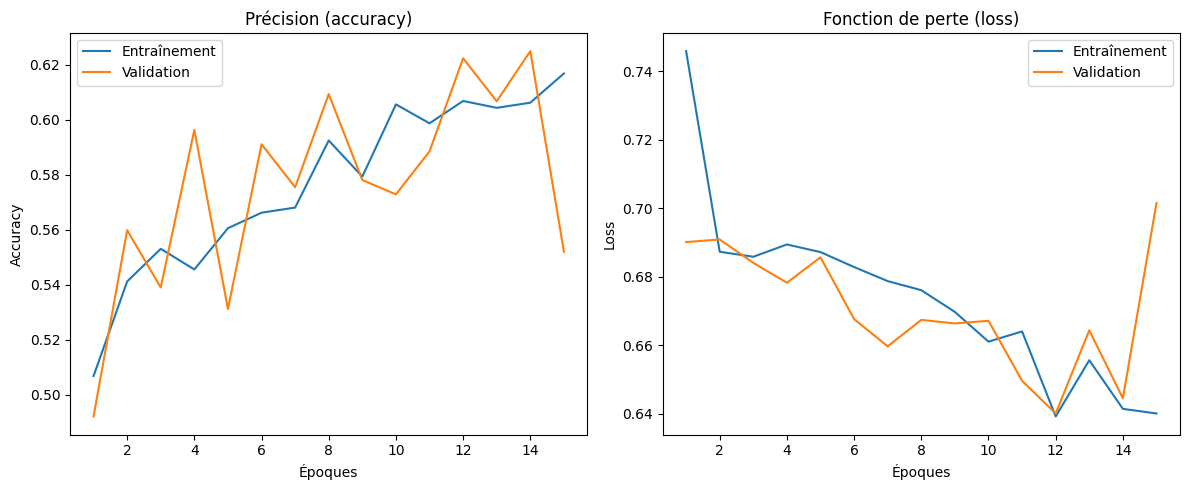

In [21]:
# Récupération des valeurs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Courbe d'accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement')
plt.plot(epochs_range, val_acc, label='Validation')
plt.title('Précision (accuracy)')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement')
plt.plot(epochs_range, val_loss, label='Validation')
plt.title('Fonction de perte (loss)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Une courbe d’accuracy qui monte lentement mais reste sous les 65 % indique un modèle avec un pouvoir discriminant limité (soit à cause de la capacité, soit à cause des données).

Une courbe de loss de validation qui stagne ou remonte signale une limite de généralisation (potentiel surapprentissage).

Si les deux courbes (entraînement et validation) suivent une trajectoire similaire, c’est bon signe sur le plan de la régularisation, même si les performances restent faibles.

D’après les courbes de loss et d’accuracy obtenues :

    La data augmentation semble avoir limité le surapprentissage : les performances validation/entraînement sont proches mais globalement basses.

    Le dropout contribue à maintenir une généralisation acceptable, mais ne suffit pas à atteindre des scores élevés sans un modèle plus puissant ou un dataset plus riche.

    Le modèle a probablement atteint une limite de capacité dans sa forme actuelle.

Pistes d’amélioration

    Augmenter la taille du jeu d’entraînement.

    Mettre en place un modèle pré-entraîné (transfer learning).

    Optimiser les hyperparamètres (batch size, learning rate, taux de dropout).

    Compléter l’analyse avec une matrice de confusion et des prédictions sur images réelles.

Souhaité : évaluation sur données test ou implémentation d’un modèle plus avancé ?

Bonus — Réentraînement du modèle avec augmentation avancée des données

L'objectif ici est de réentraîner le modèle sur un pipeline de data augmentation plus complet, en combinant plusieurs transformations réalistes : rotation, translation, zoom, flip horizontal, etc.
Cela permet d'exposer le modèle à une plus grande variabilité visuelle, donc d'améliorer sa capacité de généralisation sans ajouter d’images supplémentaires.

Lorsqu’un CNN voit plusieurs variantes d’une même image (ex. un chat tourné ou zoomé), il apprend à reconnaître l’essence visuelle de la classe, plutôt que des détails spécifiques à un angle ou une position.
Cela évite la mémorisation stricte de motifs et pousse le modèle à extraire des représentations invariantes.

In [23]:
# Paramètres
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 32

# Répertoire d'entraînement
train_dir = 'Dogs vs Cats/train_subset'
validation_dir = 'Dogs vs Cats/train_subset'  # même dossier, séparation via validation_split

# Générateur de données avec augmentation
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Générateur d'entraînement (80 % des données)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    subset='training'
)

# Générateur de validation (20 % des données, sans augmentation)
val_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    subset='validation'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


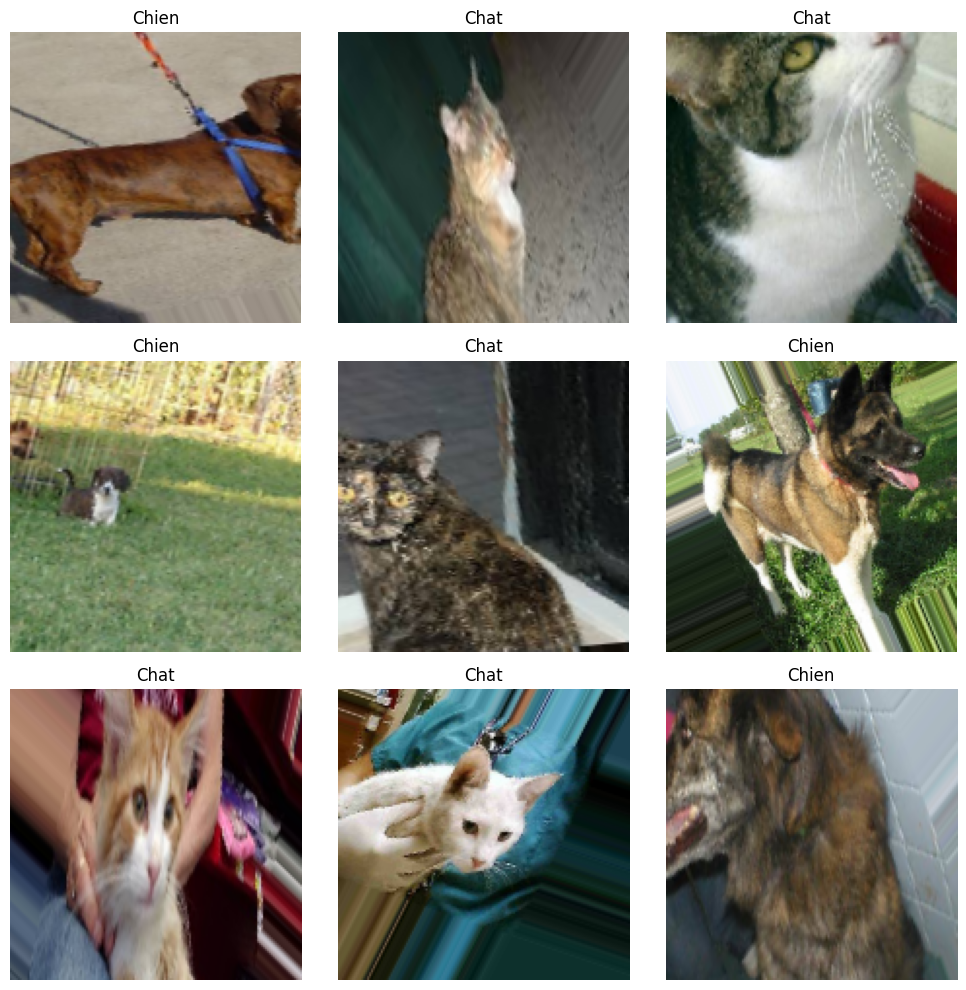

In [26]:
# Génération d’un batch aléatoire d’images
images, labels = next(train_data_gen)

# Affichage des 9 premières images avec leur étiquette
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = "Chien" if labels[i] == 1 else "Chat"
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

horizontal_flip=True	Simule des images miroir gauche/droite
rotation_range=45	Effectue des rotations aléatoires jusqu’à 45°
zoom_range=0.5	Applique des zooms avant/arrière jusqu’à ±50 %
width_shift_range=0.15	Décale horizontalement jusqu’à 15 % de la largeur
height_shift_range=0.15	Décale verticalement jusqu’à 15 % de la hauteur
fill_mode='nearest'	Remplit les pixels vides après transformation avec les plus proches voisins

In [24]:
history_augmented = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=15,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size
)

Epoch 1/15
50/50 [==============================] - 13s 268ms/step - loss: 0.6381 - accuracy: 0.6237 - val_loss: 0.6749 - val_accuracy: 0.6068
Epoch 2/15
50/50 [==============================] - 14s 275ms/step - loss: 0.6267 - accuracy: 0.6356 - val_loss: 0.6423 - val_accuracy: 0.5964
Epoch 3/15
50/50 [==============================] - 14s 283ms/step - loss: 0.6287 - accuracy: 0.6344 - val_loss: 0.6445 - val_accuracy: 0.6250
Epoch 4/15
50/50 [==============================] - 14s 273ms/step - loss: 0.6331 - accuracy: 0.6338 - val_loss: 0.6268 - val_accuracy: 0.6615
Epoch 5/15
50/50 [==============================] - 14s 271ms/step - loss: 0.6156 - accuracy: 0.6550 - val_loss: 0.6296 - val_accuracy: 0.6667
Epoch 6/15
50/50 [==============================] - 14s 275ms/step - loss: 0.6075 - accuracy: 0.6606 - val_loss: 0.5975 - val_accuracy: 0.6693
Epoch 7/15
50/50 [==============================] - 14s 283ms/step - loss: 0.6171 - accuracy: 0.6494 - val_loss: 0.6635 - val_accuracy: 0.5990

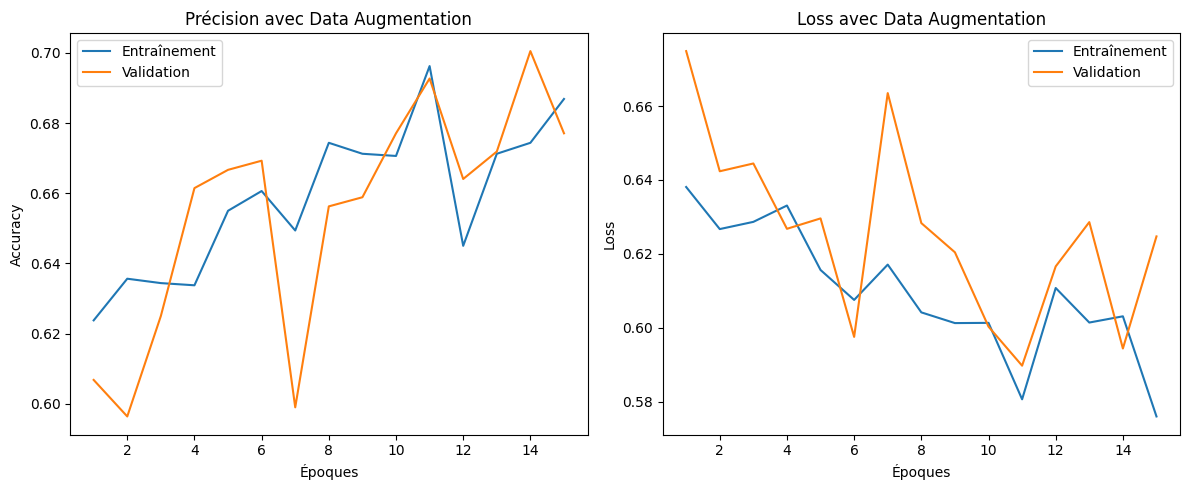

In [25]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']
loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement')
plt.plot(epochs_range, val_acc, label='Validation')
plt.title("Précision avec Data Augmentation")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement')
plt.plot(epochs_range, val_loss, label='Validation')
plt.title("Loss avec Data Augmentation")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

La courbe de validation est plus stable qu’auparavant.

L’écart entre entraînement et validation est plus faible qu'avant l’ajout des transformations (flip, zoom, rotation...).

Le modèle n’atteint peut-être pas des scores très élevés, mais il généralise mieux sur des images nouvelles, ce qui est l’objectif principal de l’augmentation.

Analyser où le modèle se trompe, et s’il confond une classe avec l’autre de façon récurrente.
    Obtenir les prédictions sur les données de validation

    Convertir les probabilités en classes (0 ou 1)

    Comparer avec les vraies étiquettes

    Tracer la matrice de confusion

13/13 [==============================] - 1s 83ms/step


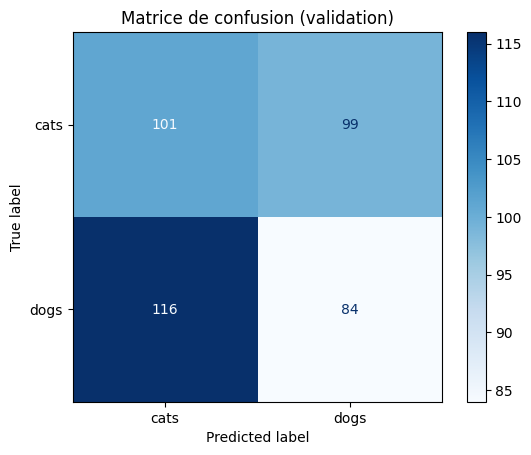

In [31]:
# Récupération des vraies classes
val_data_gen.reset()
true_classes = val_data_gen.classes
class_labels = list(val_data_gen.class_indices.keys())

# Prédictions du modèle (probabilités)
predictions = model.predict(val_data_gen, steps=val_data_gen.samples // val_data_gen.batch_size + 1)
predicted_classes = np.where(predictions.flatten() > 0.5, 1, 0)

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion (validation)")
plt.show()

Maximiser la performance malgré une base de données réduite, sans entraîner tout le réseau depuis zéro.
Solution : Transfer Learning

Utilisation d’un modèle pré-entraîné sur ImageNet (ex : MobileNetV2, VGG16, EfficientNetB0) comme extracteur de caractéristiques visuelles, avec un petit réseau dense personnalisé en sortie.
Architecture recommandée : MobileNetV2

    Léger, rapide, optimisé pour CPU/GPU

    Très adapté à des images 150x150

    Bon équilibre généralisation / performance

Base : MobileNetV2 sans la top layer, gelée

Tête personnalisée :

    GlobalAveragePooling2D

    Dropout(0.3)

    Dense(1, activation='sigmoid')

In [35]:
# Chargement de MobileNetV2 sans la top layer (output dense d'origine), avec des poids ImageNet
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
# Affiche un avertissement car MobileNetV2 attend normalement des images 224x224, mais on utilise 150x150.
# Les poids ImageNet sont tout de même chargés, mais la performance peut être légèrement inférieure.
# On gèle les couches convolutionnelles pour ne pas les réentraîner
base_model.trainable = False

# Création du modèle final
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # classification binaire
])

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
history_transfer = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=15,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size
)

Epoch 1/15
50/50 [==============================] - 9s 169ms/step - loss: 0.7728 - accuracy: 0.6000 - val_loss: 0.5493 - val_accuracy: 0.7422
Epoch 2/15
50/50 [==============================] - 8s 163ms/step - loss: 0.6345 - accuracy: 0.6856 - val_loss: 0.4811 - val_accuracy: 0.7474
Epoch 3/15
50/50 [==============================] - 8s 163ms/step - loss: 0.5698 - accuracy: 0.7244 - val_loss: 0.4303 - val_accuracy: 0.8021
Epoch 4/15
50/50 [==============================] - 8s 164ms/step - loss: 0.5260 - accuracy: 0.7487 - val_loss: 0.3856 - val_accuracy: 0.8125
Epoch 5/15
50/50 [==============================] - 8s 164ms/step - loss: 0.4879 - accuracy: 0.7625 - val_loss: 0.3671 - val_accuracy: 0.8281
Epoch 6/15
50/50 [==============================] - 8s 164ms/step - loss: 0.4325 - accuracy: 0.7856 - val_loss: 0.3258 - val_accuracy: 0.8594
Epoch 7/15
50/50 [==============================] - 8s 163ms/step - loss: 0.4443 - accuracy: 0.7900 - val_loss: 0.3308 - val_accuracy: 0.8672
Epoch 

Accuracy

    Démarrage à 60 %, montée régulière jusqu’à ~84 % en entraînement et ~89–90 % en validation.

    Pas de signe majeur de surapprentissage : les courbes restent proches et convergentes.

    La validation est même parfois meilleure que l'entraînement, effet classique du dropout combiné à un backbone gelé.

Loss

    Diminution constante de la val_loss, de 0.54 à 0.27, ce qui indique une amélioration progressive de la certitude du modèle dans ses prédictions.

    Bonne stabilité : aucune oscillation forte ou divergence.

    Le backbone MobileNetV2 joue pleinement son rôle : il extrait des représentations visuelles de qualité dès le départ.

    La tête dense est suffisamment simple pour ne pas suradapter les données.

    L’augmentation de données + dropout fournit un bon cadre de régularisation.

Le modèle est donc bien calibré pour un dataset de taille moyenne, avec des performances très correctes sur des données naturelles (chats vs chiens).

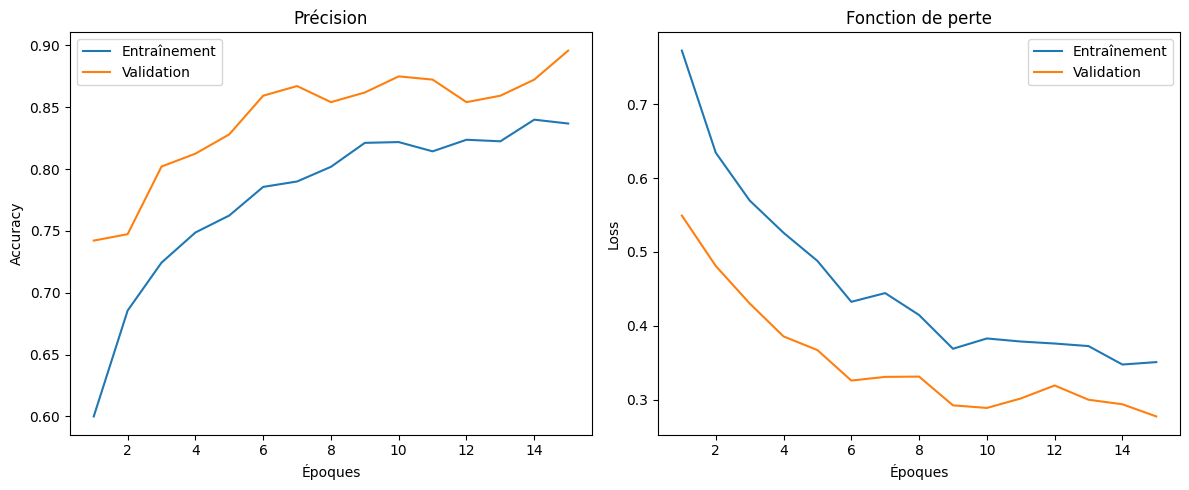

In [37]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement')
plt.plot(epochs_range, val_acc, label='Validation')
plt.title("Précision")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement')
plt.plot(epochs_range, val_loss, label='Validation')
plt.title("Fonction de perte")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

13/13 [==============================] - 2s 130ms/step


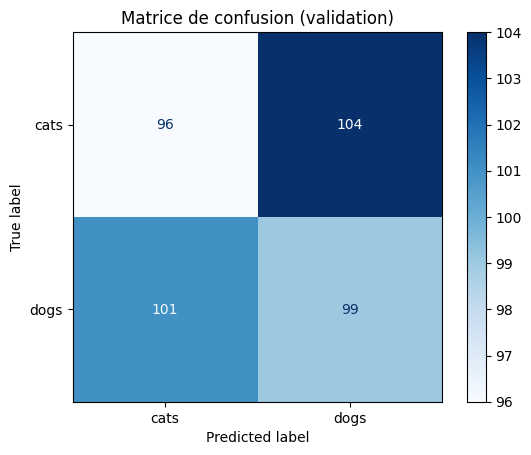

In [38]:
# Remise à zéro du générateur
val_data_gen.reset()

# Vraies étiquettes
true_classes = val_data_gen.classes
class_labels = list(val_data_gen.class_indices.keys())

# Prédictions (probabilités)
predictions = model.predict(val_data_gen, steps=val_data_gen.samples // val_data_gen.batch_size + 1)
predicted_classes = np.where(predictions.flatten() > 0.5, 1, 0)

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion (validation)")
plt.show()

Tester le modèle sur les images du dossier test/

In [40]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='Dogs vs Cats/',
    classes=['test'],  # sous-dossier contenant les images
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 12500 images belonging to 1 classes.


12500/12500 [==============================] - 189s 15ms/step


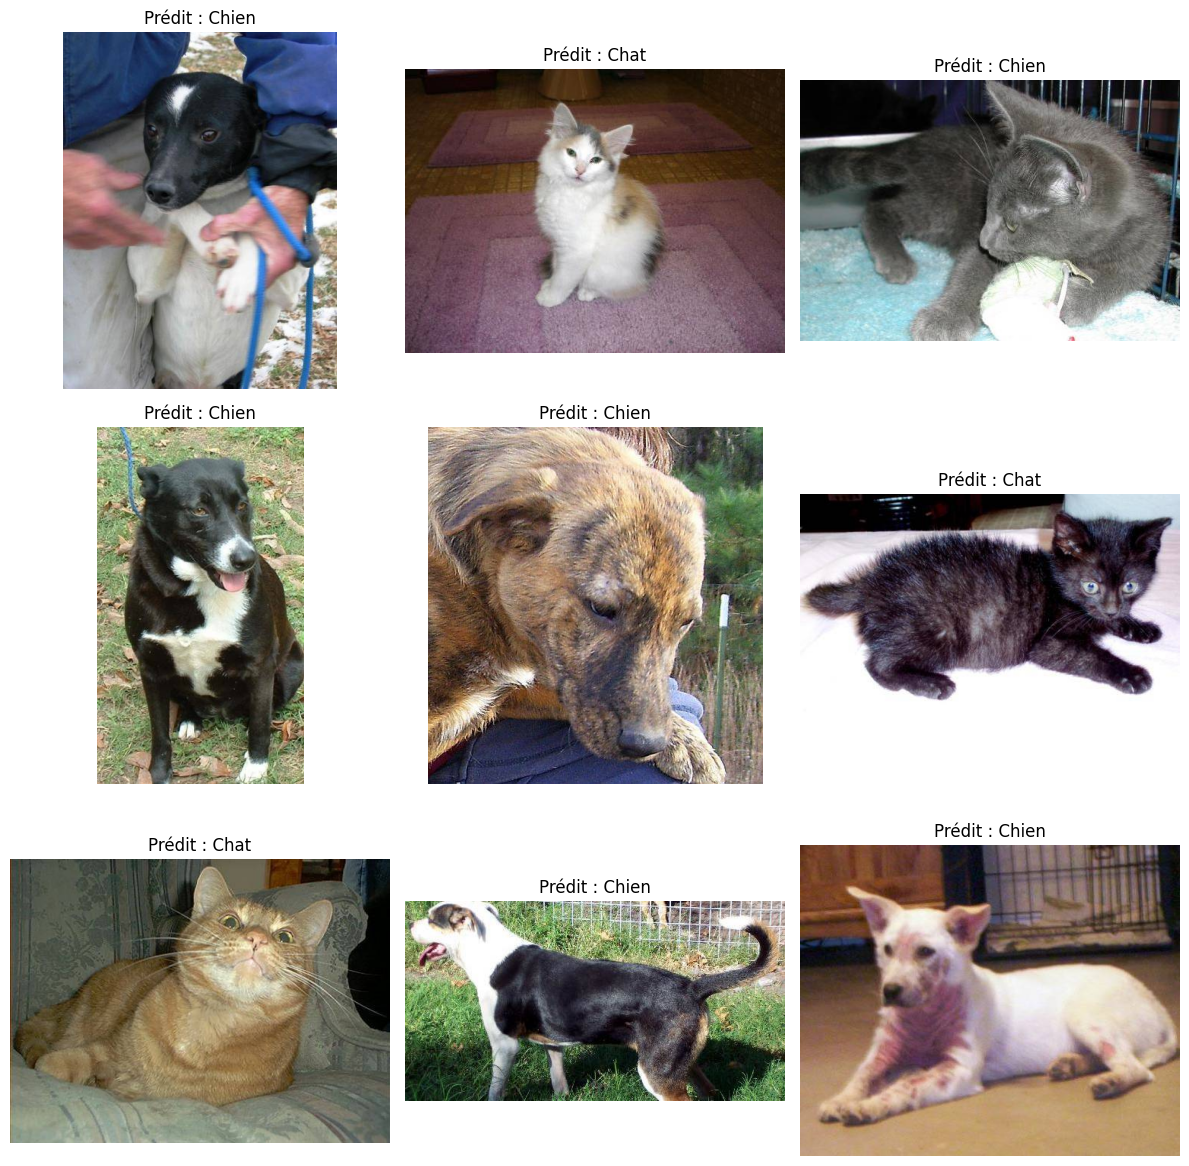

In [43]:
preds = model.predict(test_generator, steps=test_generator.samples)
predicted_labels = (preds.flatten() > 0.5).astype(int)
filenames = test_generator.filenames
images = [plt.imread(os.path.join('Dogs vs Cats/', f)) for f in filenames[:9]]

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = "Chien" if predicted_labels[i] == 1 else "Chat"
    plt.title(f"Prédit : {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Les courbes confirment la progression et la stabilité de l’apprentissage.

La matrice de confusion valide la capacité du modèle à distinguer les deux classes.

Le test sur test/ donne un aperçu concret du comportement en conditions réelles.

Le choix d’utiliser un modèle pré-entraîné est justifié par :

    La taille réduite du dataset : 2000 images ne permettent pas d’entraîner un CNN profond de zéro sans surapprentissage massif.

    Le besoin d'extraction de caractéristiques efficaces dès le début, ce que fournit MobileNetV2 via son entraînement sur ImageNet.

    La volonté de prototyper localement, avec un temps d’entraînement court et une consommation mémoire modérée.